# 分離音檔

In [ ]:
import os
import soundfile as sf

test_log_path = "E:/school/大學/專題/code/20250120_step018_/20250115_test_log.txt"

try:
    with open(test_log_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    test_log = [line.strip() for line in lines][1:]
    print(f"成功讀取檔案: {test_log_path}")
except Exception as e:
    print(f"讀取檔案錯誤: {e}")

def split_wav_file(input_file, output_dir,file_name, segment_duration=8, silence_duration=3, total_duration=90, num_files=len(test_log)):
    """
    分割 WAV 檔案為固定長度的片段。

    參數：
        input_file (str): 輸入的 WAV 檔案路徑。
        output_dir (str): 儲存分割檔案的資料夾。
        segment_duration (int): 每段音檔的長度（秒）。
        silence_duration (int): 每分割 3 個檔案後的間隔時間（秒）。
        total_duration (int): 總處理時間（秒）。
        num_files (int): 總共需要分割的檔案數量。
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 讀取音檔
    try:
        audio, sr = sf.read(input_file)
        total_samples = len(audio)
        total_time = total_samples / sr
        print(f"音檔長度: {total_time:.2f} 秒，取樣率: {sr} Hz")

        # 檢查總長度是否足夠
        required_time = (segment_duration * num_files) + (silence_duration * ((num_files // 3) - 1))
        if required_time > total_time:
            print("音檔長度不足以完成分割要求。")
            return

        # 初始化分割參數
        segment_samples = int(segment_duration * sr)
        silence_samples = int(silence_duration * sr)
        start_sample = 0

        # 分割音檔
        for i in range(num_files):
            if i > 0 and i % 3 == 0:
                start_sample += silence_samples  # 每分割 3 個檔案後空 3 秒

            end_sample = start_sample + segment_samples
            if end_sample > total_samples:
                print("超過音檔總長度，提早結束。")
                break

            # 提取片段並保存
            segment = audio[start_sample:end_sample]
            output_filename = os.path.join(output_dir, f"{file_name}_{test_log[i]}")
            sf.write(output_filename, segment, sr)

            print(f"檔案已儲存: {output_filename}")
            start_sample = end_sample
            start_sample += int(1 * sr)  # 每次空1秒

    except Exception as e:
        print(f"處理錯誤: {e}")

if __name__ == "__main__":
    directory = "E:/school/大學/專題/code/20250120_step018_/"
    output_dir = "E:/school/大學/專題/code/20250120_step018_/split_file"  # 輸出的資料夾
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print("目前目錄中的檔案:")
    for file in files:
        split_wav_file(directory+file, output_dir,file[:-4])
        print(file)


# 以下開始會是一個env

In [2]:
import json
import re

import numpy as np
import math
import librosa
import librosa.display
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

def time_to_ms(time_str):
    h, m, s = time_str.split(":")
    if "." in s:
        sec, ms = s.split(".")
        total_ms = (int(h) * 3600 + int(m) * 60 + int(sec)) * 1000 + int(ms.ljust(3, '0'))
    else:
        total_ms = (int(h) * 3600 + int(m) * 60 + int(s)) * 1000
    return total_ms

evn_folder = "F:/project/LDV_data/20250709/"
info_json = {}
with open(evn_folder + evn_folder.split('/')[-2] + "_test_log.txt", "r", encoding="utf-8") as jfile:
    info_json = json.load(jfile)



## file list##
file_list = []
tag_list = {}
# tag_list : {tag_name:{idx_interval:[start idx, end idx], seg: seg_name}}
tem = 0
for seg in info_json["Audio"]:
    for file in info_json["Audio"][seg]["file_tag"]:
        if("-" in file):
            tag_list[re.match(r"(.+_)\d", file).group(1)[:-1]] = {}
            loop_split =  file.split("-") 
            for i in range(
                int(loop_split[0].split("_")[-1])-1,    # init
                int(loop_split[1][:-4]) # final, avoid the .wav extension
                ):
                file_list.append(re.match(r"(.+_)\d", file).group(1) + f"{i+1}.wav")
            tag_list[re.match(r"(.+_)\d", file).group(1)[:-1]]["idx_interval"] = [tem+0,tem+
                                                                   (int(loop_split[1][:-4]) - 
                                                                    int(loop_split[0].split("_")[-1])  )]
            tag_list[re.match(r"(.+_)\d", file).group(1)[:-1]]["seg"] = seg
            tem = tem + int(loop_split[1][:-4]) - int(loop_split[0].split("_")[-1]) + 1



# 處理原始檔

In [ ]:
import os
from pydub import AudioSegment



# 這邊要改
segment1_start = time_to_ms("00:1:31.620")
segment1_end   = segment1_start + time_to_ms("00:13:59.563")
segment2_end   = time_to_ms("00:16:45.288")


for material in info_json["Info"]["material"]:
    for d in info_json["Info"]["deg"]:
        deg = "deg" + d
        for segment in info_json["Info"]["segment"]:
            if segment == "segment1":
                audio = AudioSegment.from_wav(evn_folder + "original/" + f"{material}_{deg}_{segment}.wav")
                trimmed = audio[segment1_start:segment1_end]
            elif segment == "segment2":
                audio = AudioSegment.from_wav(evn_folder + "original/" + f"{material}_{deg}_{segment}.wav")
                trimmed = audio[:segment2_end]
            else:
                continue
            trimmed.export(evn_folder + "complete/" + f"{material}_{deg}_{segment}_complete.wav", format="wav")


KeyboardInterrupt: 

# 標記standard file的time fram, 然後輸出json

In [4]:
# bandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist 頻率
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def split_intervals(y, top_db):
    """
    根據靜音自動切割音訊，回傳 (start, end) intervals。
    
    參數:
    y (np.ndarray): 音訊資料
    sr (int): 取樣率
    top_db (float): 靜音判斷門檻（單位 dB）

    回傳:
    List[Tuple[int, int]]: 非靜音片段的開始與結束 sample index
    """
    # 使用 librosa 的 split 函式來找到非靜音區間
    intervals = librosa.effects.split(y, top_db=top_db)
    return [(start, end) for start, end in intervals]

def split_intervals_with_padding(y, sr, top_db, padding=0.2):
    raw_intervals = librosa.effects.split(y, top_db=top_db)
    padded_intervals = []

    pad_samples = int(padding * sr)
    for start, end in raw_intervals:
        new_start = max(0, start - pad_samples)
        new_end = min(len(y), end + pad_samples)
        padded_intervals.append((new_start, new_end))
    return padded_intervals

def init_test_interval(sr):
    info_json["Standard_Interval"] = []
    info_json["Test_Interval"] = []
    pre_seg = tag_list[list(tag_list.keys())[0]]["seg"]
    time_bias = 0
    for tag in tag_list.keys():
        if(tag_list[tag]["seg"] != pre_seg):
            time_bias += time_to_ms(info_json["Audio"][pre_seg]["time_len"])
            pre_seg = tag_list[tag]["seg"]
        for i in range(tag_list[tag]["idx_interval"][0], tag_list[tag]["idx_interval"][1]+1):
            bias_sample = int(time_bias / 1000 * sr)
            if intervals[i][0] - bias_sample < 0:
                bias_sample -= abs(intervals[i][0] - bias_sample)
            
            info_json["Test_Interval"].append({
                "file_tag": tag,
                "seg":pre_seg,
                "interval": (intervals[i][0] - bias_sample, intervals[i][1] - bias_sample),
            })
            info_json["Standard_Interval"].append({
                "file_tag": tag,
                "interval": intervals[i],
            })

# set the range
lowcut = 300.0   # Hz
highcut = 20000.0 # Hz
min_duration = 0.8  # seconds

y, sr = librosa.load(evn_folder + "standard_file.wav", sr=None)
y_filtered = bandpass_filter(y, lowcut, highcut, sr, order=6)

####
test_range = 1.0 # 取每個片段中間的1 second range, 避免加到edge的值影響avg
offset = int(test_range * sr)
####

# intervals 只考慮在standard_file, segment1, segment2還要再扣掉start_pos_onStandard
intervals = split_intervals_with_padding(y, sr, top_db=70, padding=0)  # 使用 librosa 的 split 函式
intervals = [(start, end) for start, end in intervals if (end - start) / sr >= min_duration]
init_test_interval(sr)
print(len(intervals))
print(len(file_list))



541
541


# 檢查用

In [ ]:
material_list = info_json["Info"]["material"][:1] 
deg_list = info_json["Info"]["deg"][:7] # 只取後7個deg



fig_size = (6, 3)

def plot_mel_spectrogram(segment, sr, appdex_title):
    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=fig_size)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram '+ appdex_title)
    plt.tight_layout()
    plt.show()


def plt_test_interval(material, deg, interval_idx):
    """
    繪製測試區間的圖形。
    parameters:
        material (str): 材料名稱 (可輸入standard, box, ...)
        deg (str): 測試角度
        interval_idx (int): 測試區間索引
    """
    if material == "standard":
        y, sr = librosa.load(evn_folder + "standard_file.wav", sr=None)
        start, end = info_json["Standard_Interval"][interval_idx]["interval"]
    else:
        seg = info_json["Test_Interval"][interval_idx]["seg"]
        y, sr = librosa.load(evn_folder + f"complete/{material}_deg{deg}_{seg}_complete.wav", sr=None)
        start, end = info_json["Test_Interval"][interval_idx]["interval"]
    second_segment = y[start + offset : end - offset]
    plot_mel_spectrogram(second_segment, sr, f"{material} deg{deg}")

for material in material_list:
    for deg in deg_list:
        plt_test_interval(material, deg, 540)


 
data analsis

In [6]:
# test obj
material_list = info_json["Info"]["material"][:1]
deg_list = info_json["Info"]["deg"][:] # select deg
target_tag = list(tag_list.keys())[-1:]  # 只取最後一個tag, 這是white noise repeat

test_idx = []
for tag in target_tag:
    for i in range(tag_list[tag]["idx_interval"][0], tag_list[tag]["idx_interval"][1]+1):
        test_idx.append(i)
print(f'test_tag: {target_tag}, test_range:{test_range}, \nTest on \n##\nmaterial_list: {material_list}, \ndeg_list: {deg_list}')
print(f'test_idx: {test_idx}\n##')

## standard file
standard_y , standard_sr = y_filtered, sr #先前已經讀過一次standard_file
standard_freq = []#{"DB":np.zeros(1025), "size":0} #1025個頻率bin, size用來計算平均
for i in test_idx:
    start, end = info_json["Standard_Interval"][i]["interval"]
    second_segment = standard_y[start + offset : end - offset]
    D = librosa.stft(second_segment)
    DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    standard_freq.append({"deg": -90,"DB": np.mean(DB, axis=1)})    # -90 means angle of standard_file
## test file
test_freq = {}
for material in material_list:
    test_freq[material] = {}
    for deg in deg_list:
        test_freq[material][deg] = []
        pre_seg = info_json["Test_Interval"][0]["seg"]
        y, sr = librosa.load(evn_folder + f"complete/{material}_deg{deg}_{pre_seg}_complete.wav", sr=None)
        for i in test_idx:
            if(info_json["Test_Interval"][i]["seg"] != pre_seg):
                pre_seg = info_json["Test_Interval"][i]["seg"]
                y, sr = librosa.load(evn_folder + f"complete/{material}_deg{deg}_{pre_seg}_complete.wav", sr=None)
            start, end = info_json["Test_Interval"][i]["interval"]
            second_segment = y[start + offset : end - offset]
            D = librosa.stft(second_segment)
            DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            test_freq[material][deg].append({"DB": np.mean(DB, axis=1)})    #-90 means angle of standard_file
print(f'read test file done')

test_tag: ['white_noise'], test_range:1.0, 
Test on 
##
material_list: ['box'], 
deg_list: ['030', '045', '080', '085', '090', '095', '100', '105', '110', '115', '120', '125', '130', '135', '140', '145', '150']
test_idx: [538, 539, 540]
##
read test file done


# trans func & 熱力圖

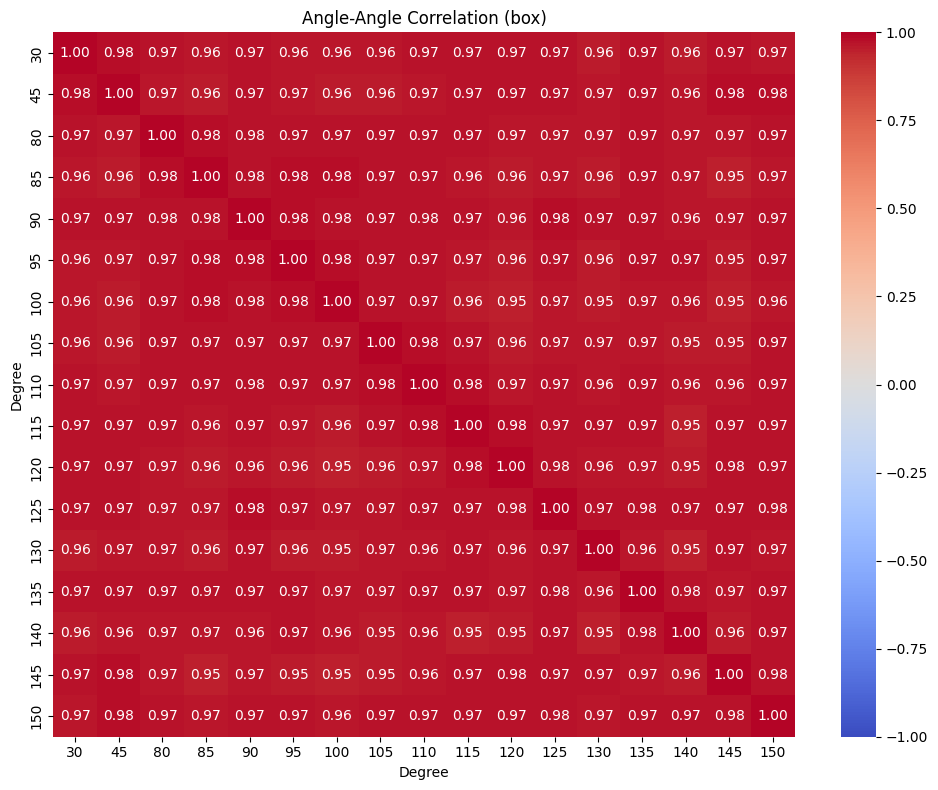

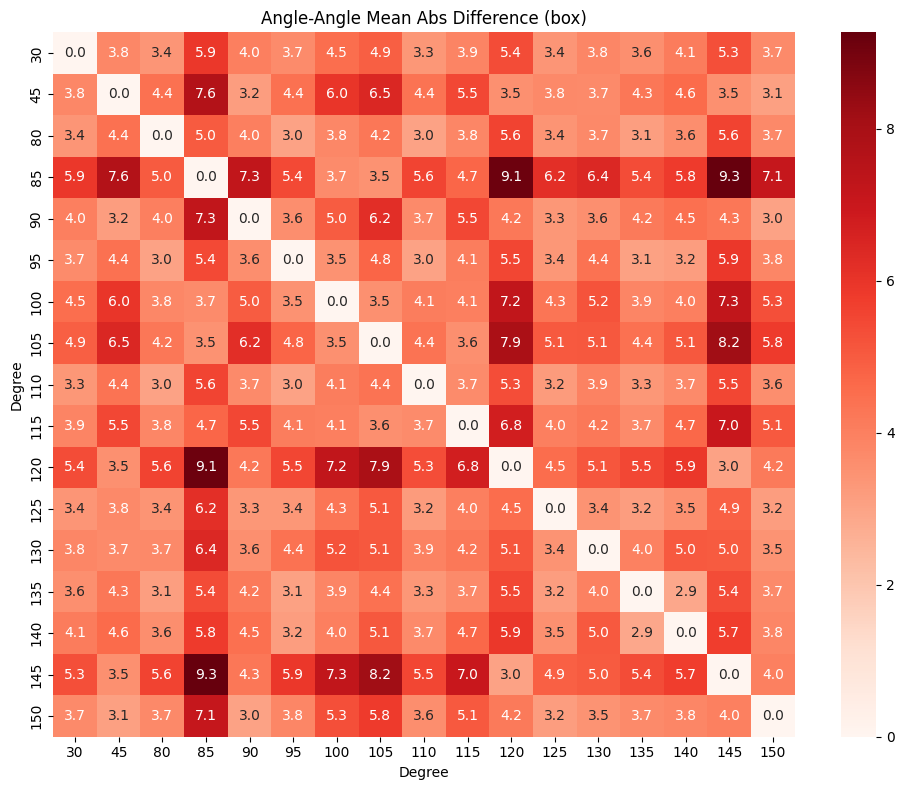

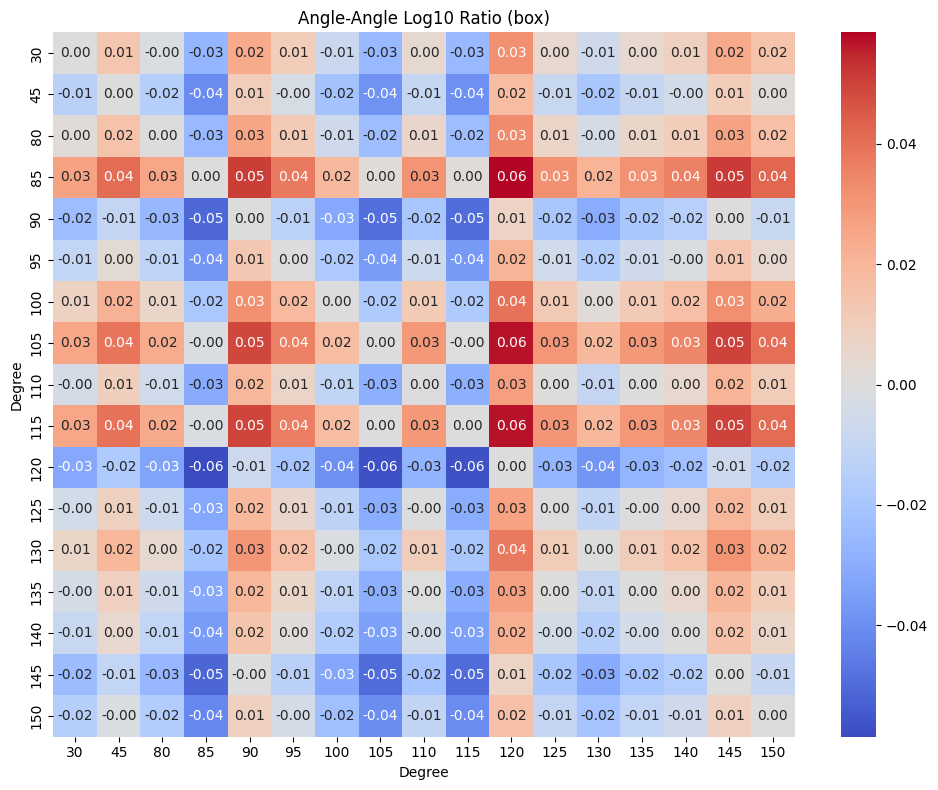

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig_size = (10, 8)

def plot_heatmap(matrix, deg_values, title, cmap="coolwarm", vmin=None, vmax=None, center=None, fmt=".2f"):
    plt.figure(figsize=fig_size)
    sns.heatmap(matrix, annot=True, fmt=fmt,
                xticklabels=deg_values, yticklabels=deg_values,
                cmap=cmap, vmin=vmin, vmax=vmax, center=center)
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Degree")
    plt.tight_layout()
    plt.show()

# 計算標準頻譜平均
standard_all_DB = np.array([item["DB"] for item in standard_freq])
standard_mean_DB = np.mean(standard_all_DB, axis=0)

for material in material_list:
    # 角度排序
    deg_sorted = sorted(test_freq[material].keys(), key=lambda d: int(d))
    deg_values = [int(d) for d in deg_sorted]

    # 每個角度的平均頻譜 (正規化後)
    all_db = []
    for deg in deg_sorted:
        db_array = np.array([item["DB"] for item in test_freq[material][deg]])
        norm_db_array = db_array - standard_mean_DB[np.newaxis, :]
        mean_db = np.mean(norm_db_array, axis=0)
        all_db.append(mean_db)
    all_db = np.array(all_db)

    # 相關性矩陣
    corr_matrix = np.corrcoef(all_db)
    plot_heatmap(corr_matrix, deg_values,
                 f"Angle-Angle Correlation ({material})",
                 cmap="coolwarm", vmin=-1, vmax=1)

    # 平均差異矩陣
    n = len(deg_values)
    diff_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            diff_matrix[i, j] = np.mean(np.abs(all_db[i] - all_db[j]))
    plot_heatmap(diff_matrix, deg_values,
                 f"Angle-Angle Mean Abs Difference ({material})",
                 cmap="Reds", fmt=".1f")

    # log10 比值矩陣
    ratio_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            with np.errstate(divide='ignore', invalid='ignore'):
                ratio = (all_db[i] + 1e-10) / (all_db[j] + 1e-10)
                ratio_matrix[i, j] = np.mean(np.log10(np.abs(ratio)))
    plot_heatmap(ratio_matrix, deg_values,
                 f"Angle-Angle Log10 Ratio ({material})",
                 cmap="coolwarm", center=0)


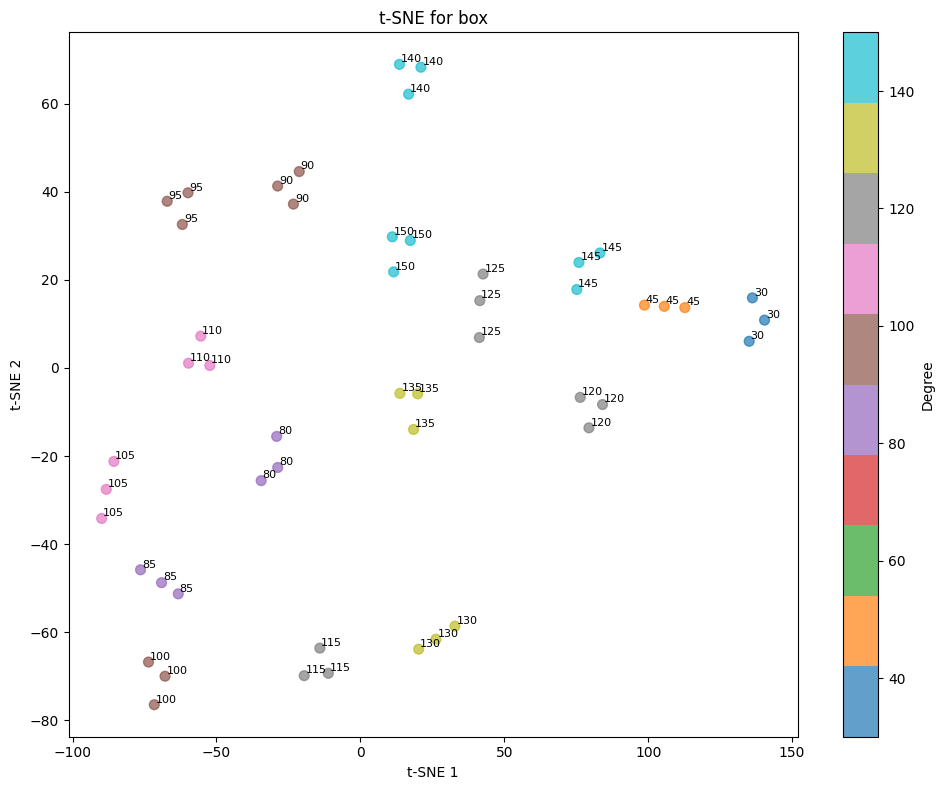

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_for_material(material, test_freq, standard_mean_DB):
    """
    對某個 material 的所有角度頻譜做 t-SNE，
    並在點旁邊標出角度。
    """
    # 角度排序
    deg_sorted = sorted(test_freq[material].keys(), key=lambda d: int(d))
    
    # 收集資料
    X = []          # 頻譜特徵
    y_labels = []   # 對應的角度
    for deg in deg_sorted:
        db_array = np.array([item["DB"] for item in test_freq[material][deg]])
        # 做標準化（可選）
        norm_db_array = db_array - standard_mean_DB[np.newaxis, :]
        for row in norm_db_array:
            X.append(row)
            y_labels.append(int(deg))

    X = np.array(X)

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    X_embedded = tsne.fit_transform(X)

    # 繪圖
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_embedded[:, 0],
        X_embedded[:, 1],
        c=y_labels,
        cmap='tab10',
        s=50,
        alpha=0.7
    )
    plt.colorbar(scatter, label="Degree")
    plt.title(f"t-SNE for {material}")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")

    # 標註角度
    for i, deg in enumerate(y_labels):
        plt.text(X_embedded[i, 0] + 0.5,
                 X_embedded[i, 1] + 0.5,
                 str(deg), fontsize=8)

    plt.tight_layout()
    plt.show()

# ==== 主程式 ====

# 計算標準頻譜平均
standard_all_DB = np.array([item["DB"] for item in standard_freq])
standard_mean_DB = np.mean(standard_all_DB, axis=0)

# 對每個 material 做 t-SNE
for material in material_list:
    plot_tsne_for_material(material, test_freq, standard_mean_DB)


# 訓練
## 單純的線性 不用非線性

Global model MSE: 17.7769
Angle 030: MSE=13.4964


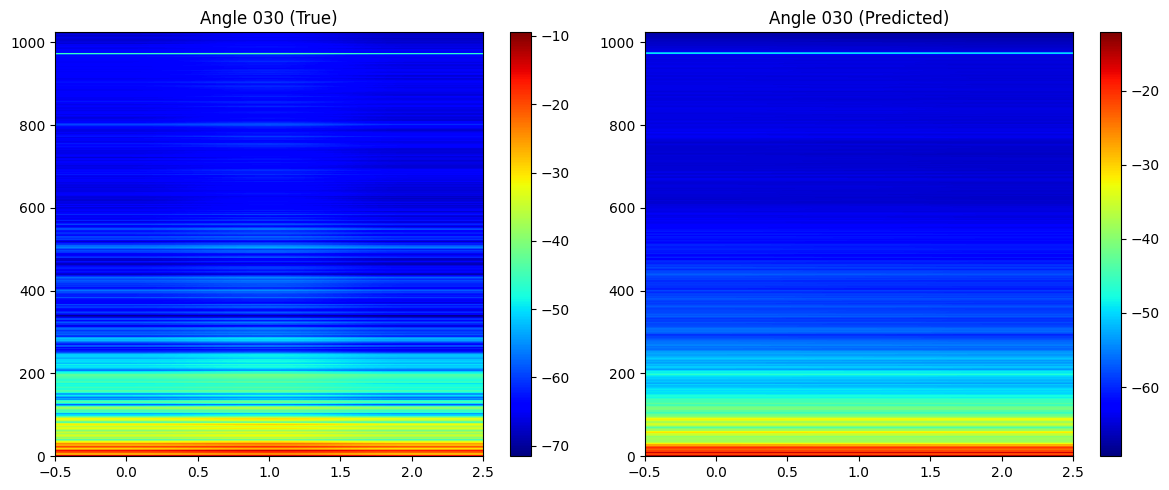

Angle 045: MSE=17.7510


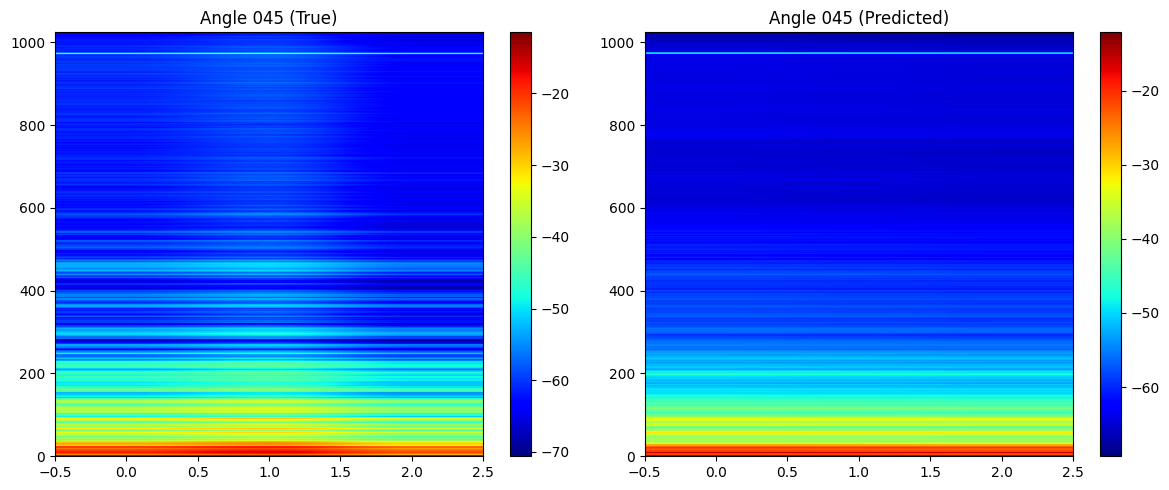

Angle 080: MSE=10.9693


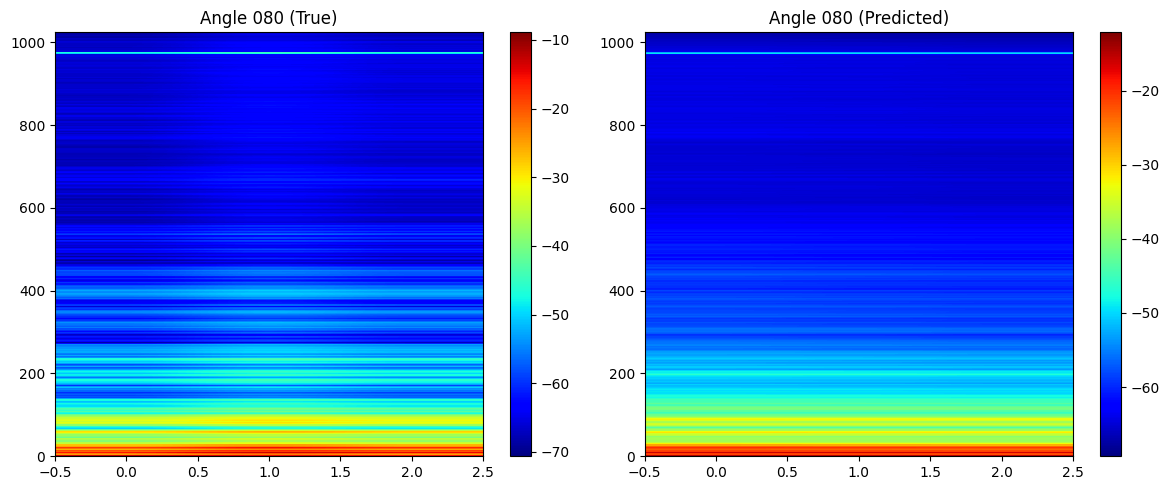

In [9]:
import numpy as np
import matplotlib.pyplot as plt

freq_bins = len(standard_freq[0]["DB"])
fig_size = (12, 5)
material = material_list[0]

# ===== 1. 準備標準資料矩陣 (所有角度會重複使用) =====
X_base = np.array([item["DB"] for item in standard_freq])  # (N, freq_bins)

# 收集所有角度的資料
X_all = []
Y_all = []
deg_index = []  # 記錄每一筆對應哪個角度，方便預測時切分

for deg in deg_list:
    Y_deg = np.array([item["DB"] for item in test_freq[material][deg]])  # (N, freq_bins)
    assert Y_deg.shape[0] == X_base.shape[0]

    X_all.append(X_base)
    Y_all.append(Y_deg)
    deg_index.extend([deg] * Y_deg.shape[0])

X_all = np.vstack(X_all)  # (N*M, freq_bins)
Y_all = np.vstack(Y_all)  # (N*M, freq_bins)
deg_index = np.array(deg_index)

# ===== 2. 一起訓練 H =====
H_global = np.linalg.pinv(X_all) @ Y_all  # (freq_bins, freq_bins)

# ===== 3. 驗證：使用相同資料預測 =====
Y_pred_all = X_all @ H_global
mse_global = np.mean((Y_all - Y_pred_all)**2)
print(f"Global model MSE: {mse_global:.4f}")

# ===== 4. 拆開結果檢視各角度預測效果 =====
def plot_compare(freq_true, freq_pred, title):
    plt.figure(figsize=fig_size)
    plt.subplot(1, 2, 1)
    plt.imshow(freq_true.T, aspect='auto', origin='lower', cmap='jet')
    plt.title(title + " (True)")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(freq_pred.T, aspect='auto', origin='lower', cmap='jet')
    plt.title(title + " (Predicted)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

for deg in deg_list[:3]:  # 只展示前3個角度
    idx = (deg_index == deg)
    Y_true = Y_all[idx]
    Y_pred = Y_pred_all[idx]
    mse = np.mean((Y_true - Y_pred)**2)
    print(f"Angle {deg}: MSE={mse:.4f}")
    plot_compare(Y_true, Y_pred, f"Angle {deg}")


# CNN

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Dataset
class TestDataset(Dataset):
    def __init__(self, standard_freq, test_freq, material, deg_list):
        self.x_list = []
        self.y_list = []
        self.deg_list = []

        standard_db_all = np.array([item["DB"] for item in standard_freq])  # (N, F)

        for deg in deg_list:
            test_db_all = np.array(
                [np.array(item["DB"], dtype=np.float32) for item in test_freq[material][deg]],
                dtype=np.float32
            )

            if test_db_all.shape[0] != standard_db_all.shape[0]:
                raise ValueError(
                    f"樣本數不一致: deg={deg}, test={test_db_all.shape[0]}, standard={standard_db_all.shape[0]}"
                )

            self.x_list.append(standard_db_all)
            self.y_list.append(test_db_all)
            self.deg_list.extend([float(deg)] * test_db_all.shape[0])

        self.x = np.concatenate(self.x_list, axis=0)
        self.y = np.concatenate(self.y_list, axis=0)
        self.deg_list = np.array(self.deg_list)

        self.min_deg = 0.0
        self.max_deg = 180.0
        self.deg_norm = (self.deg_list - self.min_deg) / (self.max_deg - self.min_deg)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.x[idx], dtype=torch.float32).unsqueeze(0)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.float32).unsqueeze(0)
        deg_tensor = torch.tensor(self.deg_norm[idx], dtype=torch.float32)
        return x_tensor, deg_tensor, y_tensor

# CNN Model
class TransFuncCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=9, padding=4)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(64 * 512 + 1, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 1025)

    def forward(self, x, deg):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.adaptive_avg_pool1d(x, 512)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, deg.unsqueeze(1)], dim=1)

        fc1_out = F.relu(self.fc1(x))
        fc1_out = self.dropout(fc1_out)
        output = self.fc2(fc1_out)

        return output.unsqueeze(1), fc1_out

# 訓練
def train_model(standard_freq, test_freq, material_list, deg_list, num_epochs=500):
    material = material_list[0]
    dataset = TestDataset(standard_freq, test_freq, material, deg_list)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransFuncCNN().to(device)

    # Loss: MSE + 0.1*L1
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x, deg, y in loader:
            x, deg, y = x.to(device), deg.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred, _ = model(x, deg)
            loss_mse = mse_loss(y_pred, y)
            loss_l1 = l1_loss(y_pred, y)
            loss = loss_mse + 0.1 * loss_l1
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(loader)
        scheduler.step(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return model

# 用法
# model = train_model(standard_freq, test_freq, material_list, deg_list, num_epochs=500)


In [11]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

dataset = TestDataset(standard_freq, test_freq, material, deg_list)
model = TransFuncCNN()

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-6)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-1)


num_epochs = 2000


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, deg, y) in enumerate(dataloader):
        x = x.to(device)
        deg = deg.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output, fc1_out = model(x, deg)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")



Epoch 1/2000, Loss: 3404.8636
Epoch 2/2000, Loss: 3383.1733
Epoch 3/2000, Loss: 3385.8347
Epoch 4/2000, Loss: 3401.5760
Epoch 5/2000, Loss: 3366.7022
Epoch 6/2000, Loss: 3368.6095
Epoch 7/2000, Loss: 3437.4882
Epoch 8/2000, Loss: 3378.2634
Epoch 9/2000, Loss: 3337.9569
Epoch 10/2000, Loss: 3384.2604
Epoch 11/2000, Loss: 3315.7426
Epoch 12/2000, Loss: 3314.6432
Epoch 13/2000, Loss: 3268.7169
Epoch 14/2000, Loss: 3326.1946
Epoch 15/2000, Loss: 3278.7181
Epoch 16/2000, Loss: 3238.7923
Epoch 17/2000, Loss: 3250.4484
Epoch 18/2000, Loss: 3151.1967
Epoch 19/2000, Loss: 3229.6649
Epoch 20/2000, Loss: 3148.8052
Epoch 21/2000, Loss: 3130.1201
Epoch 22/2000, Loss: 3070.5075
Epoch 23/2000, Loss: 3048.3797
Epoch 24/2000, Loss: 3025.4452
Epoch 25/2000, Loss: 2963.0228
Epoch 26/2000, Loss: 2949.8100
Epoch 27/2000, Loss: 2870.1785
Epoch 28/2000, Loss: 2866.9910
Epoch 29/2000, Loss: 2887.4800
Epoch 30/2000, Loss: 2748.2324
Epoch 31/2000, Loss: 2687.8820
Epoch 32/2000, Loss: 2739.3312
Epoch 33/2000, Lo

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_spectrum(model, frames, deg, device, max_frames=5):
    """
    model: 訓練好的模型
    frames: shape (time_frames, freq_bins)
    deg: 輸入的角度（0-180）
    device: 'cuda' 或 'cpu'
    max_frames: 最多顯示前幾幀的比較曲線
    """
    model.eval()
    deg_norm = deg / 180.0
    outputs = []

    with torch.no_grad():
        for frame in frames:
            x_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            deg_tensor = torch.tensor([deg_norm], dtype=torch.float32).to(device)
            y_pred, _ = model(x_tensor, deg_tensor)
            outputs.append(y_pred.squeeze().cpu().numpy())

    outputs = np.array(outputs)  # (time_frames, freq_bins)

    # --- 1. 逐幀畫對比 ---
    n_show = min(max_frames, frames.shape[0])
    for i in range(n_show):
        plt.figure(figsize=(8, 3))
        plt.plot(frames[i], label="Ground Truth", color="blue", linewidth=1)
        plt.plot(outputs[i], label="Predicted", color="orange", linewidth=1)
        plt.title(f"Frame {i} - Predicted vs Ground Truth (deg={deg})")
        plt.xlabel("Frequency bin")
        plt.ylabel("Amplitude (dB)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # --- 2. 整體 spectrogram 對比 ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(frames.T, aspect='auto', origin='lower')
    plt.title("Ground Truth Spectrogram")
    plt.xlabel("Time frame")
    plt.ylabel("Frequency bin")

    plt.subplot(1, 2, 2)
    plt.imshow(outputs.T, aspect='auto', origin='lower')
    plt.title("Predicted Spectrogram")
    plt.xlabel("Time frame")
    plt.tight_layout()
    plt.show()

    return outputs


# --- 範例呼叫 ---
# 假設 frames 來自 STFT (shape: time_frames x freq_bins)
# 這裡用你的 test_freq 資料，只取 1 筆示範：
deg = 100.0
y = test_freq["box"]["045"][2]["DB"]
# y = standard_freq[1]["DB"]
frames = np.expand_dims(y, axis=0)  # (1, freq_bins)

predicted = visualize_spectrum(model, frames, deg, device, max_frames=3)


: 

In [16]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import torch
import matplotlib
matplotlib.use("TkAgg")
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

# ---- 預測函式 ----
def predict_spectrum(model, frames, deg, device):
    model.eval()
    deg_norm = deg / 180.0
    outputs = []
    with torch.no_grad():
        for frame in frames:
            x_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            deg_tensor = torch.tensor([deg_norm], dtype=torch.float32).to(device)
            y_pred, _ = model(x_tensor, deg_tensor)
            outputs.append(y_pred.squeeze().cpu().numpy())
    return np.array(outputs)

# ---- UI 類別 ----
class SpectrumApp:
    def __init__(self, root, model, frames, device):
        self.root = root
        self.model = model
        self.frames = frames
        self.device = device
        self.cbar = None  # 用來保存 colorbar

        root.title("CNN 頻譜預測")

        mainframe = ttk.Frame(root)
        mainframe.pack(fill=tk.BOTH, expand=True)

        self.scale = tk.Scale(mainframe, from_=0, to=180, orient=tk.HORIZONTAL,
                              label="角度 (deg)", command=self.update_plot)
        self.scale.set(90)
        self.scale.pack(fill=tk.X, padx=10, pady=5)

        self.fig = Figure(figsize=(8, 6))
        self.ax1 = self.fig.add_subplot(2, 1, 1)
        self.ax2 = self.fig.add_subplot(2, 1, 2)

        self.canvas = FigureCanvasTkAgg(self.fig, master=mainframe)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        self.update_plot(90)

    def update_plot(self, val):
        deg = float(val)
        print(f"Updating plot for deg={deg}")
        outputs = predict_spectrum(self.model, self.frames, deg, self.device)

        # 清除子圖內容
        self.ax1.clear()
        self.ax2.clear()

        # --- 上圖 ---
        self.ax1.plot(self.frames[0], label="Ground Truth", color="blue", linewidth=1)
        self.ax1.plot(outputs[0], label="Predicted", color="orange", linewidth=1)
        self.ax1.set_title(f"Frame 0 頻譜 (deg={deg})")
        self.ax1.set_xlabel("Frequency bin")
        self.ax1.set_ylabel("Amplitude (dB)")
        self.ax1.legend()

        # --- 下圖 ---
        im = self.ax2.imshow(outputs.T, aspect='auto', origin='lower')
        self.ax2.set_title("Predicted Spectrogram")
        self.ax2.set_xlabel("Time frame")
        self.ax2.set_ylabel("Frequency bin")

        # 刪除舊的 colorbar
        if self.cbar is not None:
            self.cbar.remove()
        self.cbar = self.fig.colorbar(im, ax=self.ax2, orientation='vertical')

        self.fig.tight_layout()
        self.canvas.draw()


# --- 使用方式 ---
# 先準備好：
# model: 訓練好的 CNN 模型
# frames: (time_frames, freq_bins)
# device: "cuda" 或 "cpu"

root = tk.Tk()
app = SpectrumApp(root, model, frames, device)
root.mainloop()


Updating plot for deg=90.0


C:\Users\Chang Yu\AppData\Local\Temp\ipykernel_25440\930937667.py:79: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  self.fig.tight_layout()
C:\Users\Chang Yu\AppData\Local\Temp\ipykernel_25440\930937667.py:79: UserWarning: Glyph 35676 (\N{CJK UNIFIED IDEOGRAPH-8B5C}) missing from font(s) DejaVu Sans.
  self.fig.tight_layout()
C:\Users\Chang Yu\AppData\Local\Temp\ipykernel_25440\930937667.py:80: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  self.canvas.draw()
C:\Users\Chang Yu\AppData\Local\Temp\ipykernel_25440\930937667.py:80: UserWarning: Glyph 35676 (\N{CJK UNIFIED IDEOGRAPH-8B5C}) missing from font(s) DejaVu Sans.
  self.canvas.draw()
c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py:862: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  func(*args)
c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\tki

Updating plot for deg=90.0
Updating plot for deg=91.0


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Chang Yu\AppData\Local\Temp\ipykernel_25440\930937667.py", line 76, in update_plot
    self.cbar.remove()
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\colorbar.py", line 1021, in remove
    self.ax.remove()
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\artist.py", line 240, in remove
    self._remove_method(self)
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\figure.py", line 869, in delaxes
    self._remove_axes(ax, owners=[self._axstack, self._localaxes])
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\figure.py", line 884, in _remove_axes
    o

Updating plot for deg=92.0


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Chang Yu\AppData\Local\Temp\ipykernel_25440\930937667.py", line 76, in update_plot
    self.cbar.remove()
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\colorbar.py", line 1021, in remove
    self.ax.remove()
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\artist.py", line 240, in remove
    self._remove_method(self)
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\figure.py", line 869, in delaxes
    self._remove_axes(ax, owners=[self._axstack, self._localaxes])
  File "c:\Users\Chang Yu\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\figure.py", line 884, in _remove_axes
    o

In [ ]:
import re

import numpy as np
import math
import librosa
import librosa.display
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt


## file list##
file_list = []
for seg in info_json["Audio"]:
    for file in info_json["Audio"][seg]["file_tag"]:
        if("-" in file):
            loop_num = file.split("-")[1][:-4]  # avoid the .wav extension
            for i in range(int(loop_num)):
                file_list.append(re.match(r"(.+_)\d", file).group(1) + f"{i+1}.wav")



# bandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist 頻率
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def split_intervals(y, top_db=10):
    """
    根據靜音自動切割音訊，回傳 (start, end) intervals。
    
    參數:
    y (np.ndarray): 音訊資料
    sr (int): 取樣率
    top_db (float): 靜音判斷門檻（單位 dB）

    回傳:
    List[Tuple[int, int]]: 非靜音片段的開始與結束 sample index
    """
    # 使用 librosa 的 split 函式來找到非靜音區間
    intervals = librosa.effects.split(y, top_db=top_db)
    return [(start, end) for start, end in intervals]

# set the range
lowcut = 300.0   # Hz
highcut = 20000.0 # Hz

y, sr = librosa.load(evn_folder + "standard_file.wav", sr=None)
intervals = split_intervals(y)
print(len(intervals))
print(len(file_list))



1631
597


In [ ]:
#20250120 training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np



class trans_dataset(Dataset):
    def __init__(self, file_paths, labels, n_mels=200, fmin=300, fmax=4000):
        self.file_paths = file_paths
        
        # 创建标签映射
        self.label_to_index = {label: idx for idx, label in enumerate(set(labels))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}
        self.labels = [self.label_to_index[label] for label in labels]
        
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        self.samples = []  # 存储音频文件及其对应标签
        
        self._prepare_samples()
    
    def _prepare_samples(self):
        """加载音频文件，进行归一化，生成对应的Mel频谱图样本"""
        for file_path, label in zip(self.file_paths, self.labels):
            y, sr = librosa.load(file_path)
            
            y = librosa.util.normalize(y)
            
            mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax)
            mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
            self.samples.append((mel_spect, label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        mel_spect, label = self.samples[idx]
        mel_spect = torch.tensor(mel_spect, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return mel_spect, label


# 資料讀取

In [2]:
# 先做plastic而已

test_log_path = "E:/school/大學/專題/code/20250120_step018_/20250115_test_log.txt"

try:
    with open(test_log_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    test_log = [line.strip() for line in lines][1:]
    print(f"成功讀取檔案: {test_log_path}")
except Exception as e:
    print(f"讀取檔案錯誤: {e}")

freq_range  = ["500","1000","3000"]

train_data_list = []
test_data_list = []
deg_labels = []
for angle in range(0, 181, 18):
    for freq in freq_range:
        train_data_list.append(f"./20250120_step018_/split_file/plastic_deg{angle:03}_1_{freq}Hz_1.wav")
        # train_data_list.append(f"./20250120_step036_/split_file/plastic_deg{angle:03}_{freq}Hz_2.wav")
        test_data_list.append(f"./20250120_step018_/split_file/plastic_deg{angle:03}_1_{freq}Hz_1.wav")
    deg_labels.append(f"deg{angle:03}")
train_dataset = trans_dataset(train_data_list, deg_labels, n_mels=80)
test_dataset = trans_dataset(test_data_list, deg_labels, n_mels=80)
print(len(train_dataset)/len(deg_labels))

成功讀取檔案: E:/school/大學/專題/code/20250120_step018_/20250115_test_log.txt
1.0


# 定義分類器

In [3]:
class MinPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MinPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return -nn.functional.max_pool2d(-x, self.kernel_size, self.stride, self.padding)

class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# 訓練

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioClassifier(len(deg_labels))
model = model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # 1e-5 是 L2 正则化的强度


def train(batch_size,epochs):
    # 训练模型
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    print(f"batch_size={batch_size}")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for mel_spect, label in train_loader:
            # 添加一个通道维度以匹配 CNN 的输入格式
            mel_spect = mel_spect.to(device)  # 将输入数据移动到 GPU
            label = label.to(device)  # 将标签也移动到 GPU
            mel_spect = mel_spect.unsqueeze(1)  # (batch_size, 1, n_mels, time_steps)
            
            optimizer.zero_grad()
            outputs = model(mel_spect)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
      
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")
    

train(18,500)

Model is on device: cuda:0
batch_size=18
Epoch 1/500, Loss: 2.6812
Epoch 2/500, Loss: 3.8123
Epoch 3/500, Loss: 3.7346
Epoch 4/500, Loss: 2.8582
Epoch 5/500, Loss: 2.7530
Epoch 6/500, Loss: 2.5806
Epoch 7/500, Loss: 2.5979
Epoch 8/500, Loss: 2.3986
Epoch 9/500, Loss: 2.3216
Epoch 10/500, Loss: 2.3779
Epoch 11/500, Loss: 2.4121
Epoch 12/500, Loss: 2.3628
Epoch 13/500, Loss: 2.0036
Epoch 14/500, Loss: 2.0845
Epoch 15/500, Loss: 2.2896
Epoch 16/500, Loss: 2.0078
Epoch 17/500, Loss: 2.0833
Epoch 18/500, Loss: 2.0725
Epoch 19/500, Loss: 1.7136
Epoch 20/500, Loss: 1.8171
Epoch 21/500, Loss: 1.8019
Epoch 22/500, Loss: 1.6967
Epoch 23/500, Loss: 2.0380
Epoch 24/500, Loss: 1.6115
Epoch 25/500, Loss: 1.8267
Epoch 26/500, Loss: 1.6242
Epoch 27/500, Loss: 1.6049
Epoch 28/500, Loss: 1.8114
Epoch 29/500, Loss: 1.6479
Epoch 30/500, Loss: 1.6569
Epoch 31/500, Loss: 1.3986
Epoch 32/500, Loss: 1.4542
Epoch 33/500, Loss: 1.4774
Epoch 34/500, Loss: 1.2010
Epoch 35/500, Loss: 1.8042
Epoch 36/500, Loss: 1.2

# confusion matrix

Classification Report:
              precision    recall  f1-score   support

      deg000       1.00      1.00      1.00         1
      deg018       1.00      1.00      1.00         1
      deg036       1.00      1.00      1.00         1
      deg054       1.00      1.00      1.00         1
      deg072       1.00      1.00      1.00         1
      deg090       1.00      1.00      1.00         1
      deg108       1.00      1.00      1.00         1
      deg126       1.00      1.00      1.00         1
      deg144       1.00      1.00      1.00         1
      deg162       1.00      1.00      1.00         1
      deg180       1.00      1.00      1.00         1

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Overall Accuracy: 1.0000


<Figure size 5000x1200 with 0 Axes>

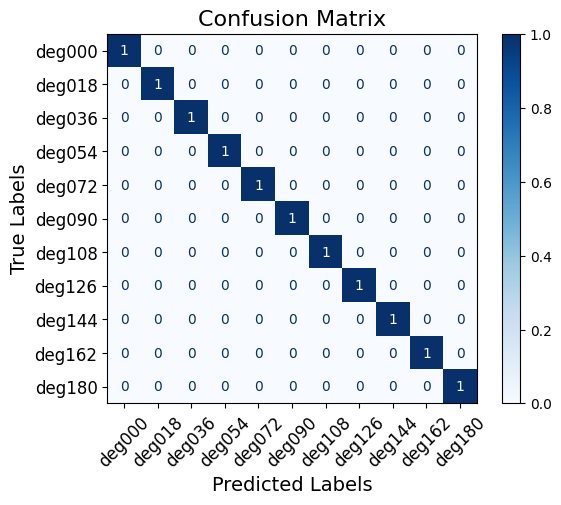

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


# 模型评估函数
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for mel_spect, labels in test_loader:
            # 移动数据到 GPU
            mel_spect = mel_spect.to(device)
            labels = labels.to(device)
            mel_spect = mel_spect.unsqueeze(1)  # 增加通道维度

            # 模型预测
            outputs = model(mel_spect)
            _, predictions = torch.max(outputs, 1)

            # 保存标签和预测结果
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    return all_labels, all_predictions

# 混淆矩阵绘制函数
def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(50, 12))
    disp.plot(cmap="Blues")
    # 调整标题、轴标签字体大小
    disp.ax_.set_title("Confusion Matrix", fontsize=16)
    disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
    disp.ax_.set_ylabel("True Labels", fontsize=14)

    # 调整 x 和 y 轴的标签字体大小
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # 旋转 x 轴的标签，以防止重叠
    plt.xticks(rotation=45)  # 旋转45度
    return cm




# 模型评估
labels, predictions = evaluate_model(model, test_loader)
# 类别名称
class_names = list(test_dataset.label_to_index.keys())  # 提取类别名称
class_names = sorted(class_names)
labels_list = list(range(len(class_names)))  # 确保类别标签正确





# 绘制混淆矩阵
cm = plot_confusion_matrix(labels, predictions, class_names)

# 打印分类报告
print("Classification Report:")

print(classification_report(labels, predictions, target_names=class_names, labels=labels_list))

# 打印总体准确率
accuracy = accuracy_score(labels, predictions)
print(f"Overall Accuracy: {accuracy:.4f}")


# DEMO

In [6]:
# 建立模型實例（假設分類數是10）
model = AudioClassifier(num_classes=10)
model.eval()  # 評估模式

# 假設你有一個函數：根據角度產生CNN輸入的tensor（1,1,H,W）
def generate_input_from_angle(angle_deg):
    # 這裡以隨機矩陣示意，實務你放Mel頻譜或實際資料
    H, W = 64, 64
    data = np.sin(np.linspace(0, np.pi, H))[:, None] * np.cos(np.linspace(0, np.pi, W))[None, :]
    # 用角度簡單變化，讓輸入隨滑桿不同
    data = data * (1 + 0.5 * np.sin(np.radians(angle_deg)))
    tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    return tensor

# 在你的 GUI callback 函數內
def on_slider_change(val):
    angle = float(val)
    angle_var.set(f"{angle:.1f}°")
    
    # 產生CNN輸入
    input_tensor = generate_input_from_angle(angle)
    
    # CNN推論（無梯度）
    with torch.no_grad():
        output = model(input_tensor)  # output shape: (1, num_classes)
    
    # 將輸出轉為numpy（shape: (num_classes,)）
    output_np = output.squeeze(0).numpy()

    # 例如把output的前100值reshape成10x10熱力圖（示意）
    # 這裡你要根據自己需求改
    heatmap_data = np.abs(output_np)[:100]
    if heatmap_data.size < 100:
        heatmap_data = np.pad(heatmap_data, (0, 100 - heatmap_data.size))
    heatmap_data = heatmap_data.reshape(10,10)

    heatmap.set_data(heatmap_data)
    heatmap.set_clim(vmin=heatmap_data.min(), vmax=heatmap_data.max())

    # 更新箭頭 (你之前的邏輯)
    radians = np.radians(angle)
    source_pos = laser_center + source_radius * np.array([np.cos(radians), np.sin(radians)])
    dir_vec = laser_center - source_pos
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    arrow_end = laser_center + offset * dir_vec
    arrow_vec = arrow_end - source_pos
    source_arrow.set_offsets([source_pos])
    source_arrow.set_UVC(arrow_vec[0], arrow_vec[1])

    canvas.draw_idle()

Selected angle: 0


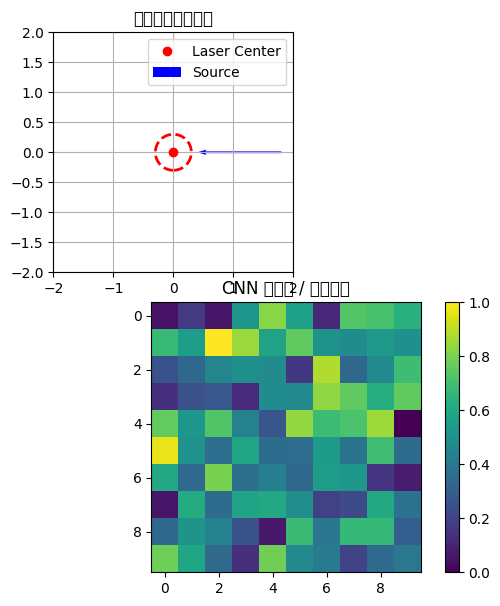

In [10]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
import torch.nn as nn

# 修改模型最後輸出為128維
class AudioClassifier(nn.Module):
    def __init__(self, output_dim=128):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2,2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)  # 輸出128維
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = AudioClassifier(output_dim=100)  # 100維，方便10x10熱力圖
model.eval()

root = tk.Tk()
root.title("聲源方向與矩陣顯示")
root.geometry("900x600")

fig = plt.figure(figsize=(7,7))
ax_vec = fig.add_axes([0.1, 0.55, 0.8, 0.4])
ax_vec.set_xlim(-2, 2)
ax_vec.set_ylim(-2, 2)
ax_vec.set_aspect('equal')
ax_vec.set_title("雷射光與聲源方向")
ax_vec.grid(True)

laser_center = np.array([0,0])
laser_radius = 0.3
laser_circle = Circle(laser_center, laser_radius, fill=False, color='red', linestyle='--', linewidth=2)
ax_vec.add_patch(laser_circle)
ax_vec.plot(*laser_center, 'ro', label='Laser Center')

source_radius = 1.8
offset = -0.4  

init_angle = 0
source_pos = laser_center + source_radius * np.array([np.cos(init_angle), np.sin(init_angle)])

source_arrow = ax_vec.quiver(source_pos[0], source_pos[1], 0, 0,
                             angles='xy', scale_units='xy', scale=1,
                             color='blue', label='Source')
ax_vec.legend(loc='upper right')

ax_mat = fig.add_axes([0.1, 0.05, 0.8, 0.45])
init_matrix = np.random.rand(10,10)
heatmap = ax_mat.imshow(init_matrix, cmap='viridis', vmin=0, vmax=1)
cbar = fig.colorbar(heatmap, ax=ax_mat, fraction=0.046, pad=0.04)
ax_mat.set_title("CNN 特徵圖 / 模擬矩陣")

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

control_frame = tk.Frame(root)
control_frame.pack(side=tk.RIGHT, fill=tk.Y, padx=20, pady=20)

label = tk.Label(control_frame, text="角度控制 (°)", font=("Arial", 14))
label.pack(pady=10)

angle_var = tk.StringVar()
angle_display = tk.Label(control_frame, textvariable=angle_var, font=("Arial", 12))
angle_display.pack(pady=5)

def generate_input_from_angle(angle_deg):
    H, W = 64, 64
    base_pattern = np.sin(np.linspace(0,np.pi,H))[:,None] * np.cos(np.linspace(0,np.pi,W))[None,:]
    data = base_pattern * (1 + 0.5*np.sin(np.radians(angle_deg)))
    tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return tensor

def on_slider_change(val):
    angle = float(val)
    angle_var.set(f"{angle:.1f}°")
    
    step = 15
    rounded_value = round(int(float(val)) / step) * step
    angle_var.set(rounded_value)  # 設定滑桿顯示的值為四捨五入後的值
    print(f"Selected angle: {rounded_value}")

    input_tensor = generate_input_from_angle(angle)

    with torch.no_grad():
        output = model(input_tensor)  # (1, 100)
    output_np = output.squeeze(0).numpy()

    heatmap_data = output_np.reshape(10, 10)

    # 正規化到 0~1
    norm_data = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min() + 1e-8)

    heatmap.set_data(norm_data)
    heatmap.set_clim(0, 1)

    # 更新箭頭 (你之前的邏輯)
    radians = np.radians(angle)
    source_pos = laser_center + source_radius * np.array([np.cos(radians), np.sin(radians)])
    dir_vec = laser_center - source_pos
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    arrow_end = laser_center + offset * dir_vec
    arrow_vec = arrow_end - source_pos
    source_arrow.set_offsets([source_pos])
    source_arrow.set_UVC(arrow_vec[0], arrow_vec[1])

    canvas.draw_idle()

angle_slider = ttk.Scale(control_frame, from_=0, to=180, orient="horizontal", command=on_slider_change)
angle_slider.set(0)
angle_slider.pack(pady=10, fill=tk.X)

angle_var.set("0.0°")

root.mainloop()


# TSNE

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# 定義自定義的卷積層
class AudioClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 6 輸入通道，32 輸出通道
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((1, 1))  # 把特徵圖壓縮為 (batch_size, 128, 1, 1)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def get_features(self, x):
        # 返回卷积层的输出 (即特征图)
        x = self.conv_layers(x)
        return x.view(x.size(0), -1)  # 展平卷积层的输出以便于 t-SNE

# 模拟数据
batch_size = 8
input_channels = 1
height = 80
width = 345
num_classes = 6


# 隨機生成數據
# inputs = torch.randn(batch_size, input_channels, height, width)
# labels = torch.randint(0, num_classes, (batch_size,))

# 創建 DataLoader
test_dataset = trans_dataset(test_data_list, deg_labels, n_mels=80)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# 初始化模型和設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AudioClassifier(num_classes=num_classes).to(device)

# 将模型设为评估模式
model.eval()

# 提取特征
features = []
true_labels = []

with torch.no_grad():
    for inputs_batch, labels_batch in test_loader:
        inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)
        feature_batch = model.get_features(inputs_batch)
        features.append(feature_batch.cpu().numpy())  # 转回 CPU
        true_labels.append(labels_batch.cpu().numpy())

# 合并所有特征和标签
features = np.vstack(features)
true_labels = np.concatenate(true_labels)

# 应用 t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # 将 perplexity 设置为小于样本数
features_tsne = tsne.fit_transform(features)

# 绘制 t-SNE 结果
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=true_labels, cmap='tab10', s=50)
plt.colorbar()  # 显示颜色条
plt.title("t-SNE of Audio Classifier Features")
plt.show()


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 11, 80, 345] to have 1 channels, but got 11 channels instead

In [315]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


# Assuming you have a dataloader for your dataset
def visualize_tsne(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_fc_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move data to the same device as the model (if using CUDA)
            inputs = inputs.to(device)  # For CUDA use .to(device)
            labels = labels.to(device)
            
            # Forward pass through the model
            _, fc_output = model(inputs)  # Get FC layer outputs
            
            all_fc_outputs.append(fc_output.cpu().numpy())  # Store outputs on CPU
            all_labels.append(labels.cpu().numpy())  # Store labels on CPU

    # Concatenate all outputs
    all_fc_outputs = np.concatenate(all_fc_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(all_fc_outputs)

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=all_labels, cmap='viridis', s=10)
    plt.colorbar()  # Show color bar for labels
    plt.title("t-SNE of FC Layer Outputs")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# Example of using the function
visualize_tsne(model, test_loader)


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 6, 80, 345] to have 1 channels, but got 6 channels instead